In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

seq_length = 1

def sort(batch):
    return np.sort(batch)

def reverse(batch):
    return np.flip(batch, axis=1)

def copy(batch):
    return batch

def decimal2binary(data, vec_dim):
    out = []
    for i in data:
        out.append([int(s) for s in list(bin(i)[2:].zfill(vec_dim))])
    return out 

def binary2decimal(data):
    bd = len(data[0])
    twos = []
    for i in range(1, bd+1):
        twos.append(2**(bd-i))
    twos = np.array(twos)
    return np.sum(data*twos, axis=-1)

def binary2decimal_batch(batch):
    batch_size, seq_length, vec_dim = batch.shape
    twos = tf.reshape(2**(vec_dim - 1 - tf.range(0, vec_dim, 1.0)), shape=(1, 1, vec_dim))
    twos_batch = tf.tile(twos, tf.constant([batch_size, seq_length, 1], tf.int32))
    return tf.reduce_sum(batch*twos_batch, axis=2)

def random_X(seq_length=4, vec_dim=4):
    return [[0]+np.random.choice([0, 1], vec_dim).tolist() for i in range(seq_length)]

def get_Z_corresponding_to(X):
    batch_size, seq_length, vec_dim = X.shape
    #print(X.shape)
    Z = tf.concat([tf.reshape(tf.tile(tf.eye(vec_dim)[0], 
                                      #tf.ones(vec_dim), 
                                      tf.constant([batch_size], tf.int32)), 
                                     (batch_size, 1,            vec_dim)), 
                      tf.zeros(shape=(batch_size, seq_length-1, vec_dim))], axis=1)
    return Z

def get_XY(seq_length=4, vec_dim=4, size=100, f=sort):
    X = [random_X(seq_length, vec_dim) for _ in range(size)]
    Y = [decimal2binary(f([binary2decimal(x)])[0], vec_dim) for x in X]
    return X, Y

def get_binary_dataset(seq_length=4, vec_dim=4, size=100, f=reverse):
    X, Y = get_XY(seq_length, vec_dim, size, f=f)
    X = np.array(X).astype(np.float32)
    Y = np.array(Y).astype(np.float32)
    return tf.data.Dataset.from_tensor_slices((X, Y))

def loss_sum(y, z):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=z, name=None))

def update(X, Y, model, optimizer): # 学習ステップ
    batch_size = X.shape[0]
    init_h = model.reset_states(batch_size)
    with tf.GradientTape() as tape:
        # encoding step
        _, enc_h = model(X, h=init_h)# 後でmodelを定義する際 call すると (出力, 内部状態) が出るようにしてあります
        # decoding step
        Z = get_Z_corresponding_to(X)
        Y_pred, _ = model(Z, h=enc_h) # 後でmodelを定義する際 call すると (出力, 内部状態) が出るようにしてあります
        # loss
        loss_value = loss_sum(Y, Y_pred) 
    # update
    #grads, _  = tf.clip_by_global_norm(tape.gradient(loss_value, model.trainable_variables), 20)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_value

class NaiveModel(tf.keras.Model):
    def __init__(self, vec_dim, cell, batch_size):
        super(NaiveModel, self).__init__()
        self.rnn_cell = cell
        self.rnn = tf.keras.layers.RNN(cell=cell, return_sequences=True, return_state=True)#, stateful=True)
        self.dense = tf.keras.layers.Dense(vec_dim,
                                           kernel_initializer='glorot_normal', bias_initializer='normal',
                                           name='final_dense_params')
        self(np.zeros((batch_size, 2, vec_dim+1), dtype=np.float32), self.reset_states(batch_size))
             #None) # build
        
    def call(self, inputs, h):
        x = inputs
        x_and_states = self.rnn(x, initial_state = h) # return_state=True になっている場合、最終の内部状態が出力される
        x = self.dense(x_and_states[0])
        return x, x_and_states[1:]
        
    def reset_states(self, batch_size):
        return self.rnn_cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)
    
def plot_binaries(y, ax=None, given_seq_length=None, title=None):
    vec_dim, seq_length = y.shape
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
    if title is not None:
        ax.set_title(title)
    ax.set_yticks([n for n in range(vec_dim)])
    ax.set_yticklabels([r"$2^{}$".format(vec_dim-1-n) for n in range(vec_dim)])
    #ax.set_xticks([t for t in range(seq_length)])
    ax.set_xlabel("t")
    mappable = ax.imshow(y,interpolation='nearest',vmin=0,vmax=1,cmap='gray_r')
    #
    if given_seq_length is not None:
        ax.axvline(x=given_seq_length, ymin=0, ymax=30, color='red', ls="-.")
        arrow_dict = dict(arrowstyle = "->", color = "red", connectionstyle = "arc")
        ax.annotate("max l in data", xy = (given_seq_length, 0), size = 10, 
                    xytext = (given_seq_length, -vec_dim//2), color = "red", arrowprops = arrow_dict)
    return mappable

def test(X, model, f, given_seq_length, bin=True, threshold=0.5, w=False, show=True): 
    Y = np.array([decimal2binary(f([binary2decimal(np.array(X[0], dtype=np.int))])[0], vec_dim)])
    batch_size = X.shape[0]
    init_h = model.reset_states(batch_size)
    #
    _, enc_h = model(X, h=init_h)
    Z = get_Z_corresponding_to(X)
    Y_pred, _ = model(Z, h=enc_h)
    #Y_pred = Y_pred[:, :-1]
    #
    if show:
        fig = plt.figure(figsize=(14, 6))
        ax0 = fig.add_subplot(2,2,1)
        ax1 = fig.add_subplot(2,2,2)
        ax2 = fig.add_subplot(2,2,4)
        mappable0 = plot_binaries(X[0].numpy().T, ax0, 
                                  given_seq_length, 'Input')
        mappable1 = plot_binaries(np.array(decimal2binary(f([binary2decimal(np.array(X[0], dtype=np.int))])[0], vec_dim), dtype=np.float).T, ax1, 
                                  given_seq_length, 'Target({})'.format(str(f).split(" ")[1]))
        mappable2 =plot_binaries(((tf.keras.activations.sigmoid(Y_pred).numpy())[0]).T, ax2, 
                                 given_seq_length, 'RNN output')
        fig.colorbar(mappable0, ax=ax0)
        fig.colorbar(mappable1, ax=ax1)
        fig.colorbar(mappable2, ax=ax2)
        plt.show()

    elif bin:
        #print("in    :")
        #print(X[0].numpy().astype(np.float32).T + 0.01)
        print("ans   :")
        print(np.abs(np.array(decimal2binary(f([binary2decimal(np.array(X[0], dtype=np.int))])[0], vec_dim), dtype=np.float).T- 0.01))#[:-1])
        print("model :")
        print((np.round((tf.keras.activations.sigmoid(Y_pred).numpy()), 2)[0]).T)
    else:
        print("in    :", binary2decimal(X[0]))
        print("ans   :", f([binary2decimal(X[0])])[0])
        print("model :", binary2decimal(1.0*(tf.keras.activations.sigmoid(Y_pred).numpy()>threshold)[0]))

        
    if w:
        state = model.reset_states(batch_size)
        enc_slots = []
        for t in range(X.shape[1]):
            _, state = model(X[:,t:t+1,:], h=state)
            enc_slots.append((np.argmax(tf.squeeze(state[1])), np.argmax(tf.squeeze(state[2]))))


        dec_slots = []
        for t in range(Z.shape[1]):
            _, state = model(Z[:,t:t+1,:], h=state)
            dec_slots.append((np.argmax(tf.squeeze(state[1])), np.argmax(tf.squeeze(state[2]))))
        print('encode w (r, w) :', enc_slots)
        print('decode w (r, w):', dec_slots)

## 7-1. LSTMでアルゴリズム学習してみる

この節における**アルゴリズム**は、正数列$\to$正数列の何らかの関数であるとします。これは例えば以下のような関数：`identity`,`sort`,`reverse` のようなものとします。

In [3]:
x = [[1, 9, 6, 8, 8, 4]]
print("x =".ljust(13, ' ')          , x                  )
print("identity(x) =".ljust(13, ' '), x                  )
print("sort(x) =".ljust(13, ' ')    , sort(x).tolist()   )
print("reverse(x) =".ljust(13, ' ') , reverse(x).tolist())

x =           [[1, 9, 6, 8, 8, 4]]
identity(x) = [[1, 9, 6, 8, 8, 4]]
sort(x) =     [[1, 4, 6, 8, 8, 9]]
reverse(x) =  [[4, 8, 8, 6, 9, 1]]


順に、
* `identity`：恒等写像
* `sort`：降順に並び替える関数
* `reverse`：逆順に並び替える関数

と言う具合です。かなり単純ですが、一応、論理的な処理が必要な関数を用意したつもりです。これらの関数を、データだけから推論させることを考えます。つまり、教師データとして

In [4]:
X = np.random.randint(1, 10, 3*10).reshape(3, 10)
print("Input X :\n", X)
print("Output Y :\n", sort(X))

Input X :
 [[7 4 2 3 7 4 9 3 4 6]
 [5 3 6 8 6 4 4 6 6 7]
 [4 6 4 8 8 8 7 8 7 3]]
Output Y :
 [[2 3 3 4 4 4 6 7 7 9]
 [3 4 4 5 6 6 6 6 7 8]
 [3 4 4 6 7 7 8 8 8 8]]


のようなものを適当に生成し、その**データの構造だけからどのようなアルゴリズムでこれが作られたかを推定するタスク**をニューラルネットワークに解かせることを考えます。どのようなネットワークを使ってもよいのですが、
* 論理的な処理は時系列データ処理と思える
* リカレントニューラルネットワークは**チューリング完全**であることが知られている([Siegelmann, H. T., & Sontag, E. D. (1992)](https://www.sciencedirect.com/science/article/pii/S0022000085710136))

ことから、今回は数列を時系列データとして処理するリカレントニューラルネットワークを使ってみます。

### データの前処理

上のように数字の並びに対する処理を解かせたいのですが、整数を直に扱うのはネットワークにとって少々難しいので、何らかの方法でベクトル化する必要があります。今回は実装の単純さの観点から**２進数(バイナリ)表示**を使ってみることにします。

例えば、以下のような感じで、各時刻での整数 1, 9, 6, ..., を2進数で表記した際、例えば

$$
\left. \begin{array}{rrr}
1 = & 1 \cdot 2^0 \to & 1
\\
9 = & 1\cdot2^3 + 0 \cdot 2^2 + 0 \cdot 2^1 + 1 \cdot 2^0 \to & 1001
\\
\vdots
\\
4 = &  1 \cdot 2^2 + 0 \cdot 2^1 + 0 \cdot 2^0 \to & 100
\end{array} \right.
$$

といった具合ですが、適当に上限サイズ（`vec_dim`に対応）を固定し、足りない分を0で埋め、その各桁を成分に持つベクトルに変換します。そして最後に ${\color{red}{EOS}}$ を表すベクトルとして、第一成分のみ1であとはゼロのベクトルを埋め込みます（つまり、もとの数列の長さ+1の長さの２進数表記ベクトル列に変換します）：

$$
\left. \begin{array}{rrrl}
1 \to &1 \to &"00000"1 \to & [0,0,0,0,0,1] = {\bf x}_0
\\
9 \to &1001 \to &"00"1001 \to & [0,0,1,0,0,1] = {\bf x}_1
\\
\vdots & & &\vdots
\\
4 \to & 100 \to & "000"100 \to & [0,0,0,1,0,0] = {\bf x}_5
\\
 && {\color{red}{+}}& {\color{red}{[1,0,0,0,0,0]=:  {EOS}}} 
\end{array} \right.
$$

ただし、実装の都合上 ${\color{red}{EOS}}$ は別の形で実装します。コマンド`decimal2binary` で数のリストをバイナリベクトルに変換できるようにしておきました：


[1, 9, 6, 8, 8, 4] is transformed to


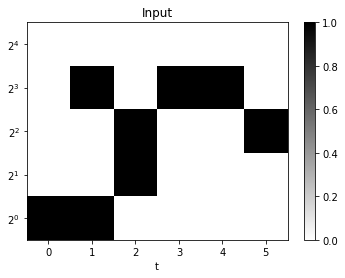

In [10]:
print(x[0], "is transformed to")
mappable = plot_binaries(np.array(decimal2binary(x[0], vec_dim=5)).T, title='Input')
plt.colorbar(mappable); plt.show()

この入力に対して、アルゴリズムを `f` とすると、教師信号は以下になります。注意ですが、出力では ${\color{red}{EOS}}$ が不要なので無駄を省くために一番大きな位（一番左の`0`ばかりの位）を切り捨てて、ベクトルの次元を1減らしています。このあたりの処理は後で使うデータ処理用の関数で実装してあります。

[1, 9, 6, 8, 8, 4] is transformed to


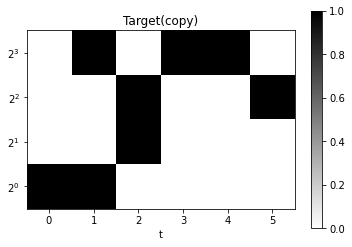

In [13]:
f = copy # reverse, sort is also possible
print(f(x)[0], "is transformed to")
mappable = plot_binaries(np.array(decimal2binary(f(x)[0], vec_dim=4)).T, title='Target({})'.format(str(f).split(" ")[1]))
plt.colorbar(mappable); plt.show()

### 訓練の方法
[4節](#)でリカレントニューラルネットワークを使いましたが、あのときは毎時刻の出力を見ていましたが、今回のアルゴリズム学習では、一旦入力の系列を全て把握しないと、正しい答えが出せません。そこで以下のような形式（エンコーダー・デコーダー形式）を採ることにします：

![alt](1.jpg)



エンコードステップではEOSを含まないベクトル系列 ${\color{blue}{X = [{\bf x_0}, {\bf x}_1, \dots]}}$ を入力し、出力は無視してリカレントニューラルネットワークの内部状態だけを更新します。そしてデコードステップでは${\color{red}{Z = [EOS, {\bf 0}, {\bf 0}, \dots]}}$ を入力して、教師データ ${\color{red}{Y = [{\bf y_0}, {\bf y}_1, \dots]}}$ に合わせに行くように教師あり学習を行います。ここでは 
* `get_binary_dataset` : $X, Y$ を用意
* `get_Z_corresponding_to(X)` : 対応するZを出力する

というコマンドを準備しました：

In [14]:
D = get_binary_dataset(seq_length=3, vec_dim=3, size=1, f=reverse) # size = number of data
batch = D.shuffle(50).batch(1, drop_remainder=True)
for X,Y in batch:
    print("X:\n", X, "\n in decimal: \n", binary2decimal_batch(X).numpy())
    print("Z:\n", get_Z_corresponding_to(X))
    print("Y:\n", Y, "\n in decimal: \n", binary2decimal_batch(Y).numpy())

X:
 tf.Tensor(
[[[0. 1. 1. 0.]
  [0. 0. 1. 0.]
  [0. 1. 1. 1.]]], shape=(1, 3, 4), dtype=float32) 
 in decimal: 
 [[6. 2. 7.]]
Z:
 tf.Tensor(
[[[1. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]], shape=(1, 3, 4), dtype=float32)
Y:
 tf.Tensor(
[[[1. 1. 1.]
  [0. 1. 0.]
  [1. 1. 0.]]], shape=(1, 3, 3), dtype=float32) 
 in decimal: 
 [[7. 2. 6.]]


EOSを表すベクトルが $[1, 0, \dots, 0]$ だったことに注意してください。訓練は出力がバイナリーなので、sigmoidクロスエントロピーを使いますが、別の誤差関数でも似た働きをするものであれば代用できます：

In [15]:
def loss_sum(y, z):
    #return tf.reduce_mean(tf.keras.losses.MSE(y, tf.keras.activations.sigmoid(z)))
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=z, name=None))

適当なミニバッチ $X, Y$ がやってきたときの `model` の訓練の処理は

In [16]:
def update(X, Y, model, optimizer): # 学習ステップ
    batch_size = X.shape[0]
    init_h = model.reset_states(batch_size)
    with tf.GradientTape() as tape:
        # encoding step
        _, h_encoded = model(X, h=init_h)# 後でmodelを定義する際 call すると (出力, 内部状態) が出るようにしてあります
        # decoding step
        Z = get_Z_corresponding_to(X)
        Y_pred, _ = model(Z, h=h_encoded) # 後でmodelを定義する際 call すると (出力, 内部状態) が出るようにしてあります
        # loss
        loss_value = loss_sum(Y, Y_pred) 
    # update
    #grads, _  = tf.clip_by_global_norm(tape.gradient(loss_value, model.trainable_variables), 20)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_value

のようにするとします。あとは `model` の設計をして実際に訓練するのみです。

### モデルの定義
まずは前にも使ったtensorflowに据え置きのリカレントニューラルネットワークを組み込んだモデルを作ります。これは時系列方向が暗黙のうちに固定されていると考えれば、これまでと同じ作り方です

In [17]:
class NaiveModel(tf.keras.Model):
    def __init__(self, vec_dim, cell, batch_size):
        super(NaiveModel, self).__init__()
        self.rnn_cell = cell
        self.rnn = tf.keras.layers.RNN(cell=cell, return_sequences=True, return_state=True)#, stateful=True)
        self.dense = tf.keras.layers.Dense(vec_dim,
                                           kernel_initializer='glorot_normal', bias_initializer='normal',
                                           name='final_dense_params')
        self(np.zeros((batch_size, 1, vec_dim+1), dtype=np.float32), None) # build
        
    def call(self, inputs, h):
        x = inputs
        x_and_states = self.rnn(x, initial_state = h) # return_state=True になっている場合、最終の内部状態が出力される
        x = self.dense(x_and_states[0])
        return x, x_and_states[1:]
        
    def reset_states(self, batch_size):
        return self.rnn_cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)

`cell` という見慣れない変数を導入しましたが、どうやらtensorflowでは

* リカレントニューラルネットワークのコア部分は`cell`として実装し
* 実際にリカレントニューラルネットワークを作る際は`tf.keras.layers.RNN(cell)` とする

としてリカレントニューラルネットワークを作ることができるみたいです。前回の `SimpleRNN` に相当する部分が `self.rnn = tf.keras.layers.RNN(...)` の部分です。

### 訓練してみる
データが与えられたときの訓練用の関数は以下のようになります：

In [18]:
def train(model, D, epoch_size=10, batch_size=32, savepath=''):
    tf_update = tf.function(update) # グラフ化
    optimizer=tf.keras.optimizers.Adam()
    ### training
    for epoch in range(epoch_size):
        batch = D.shuffle(50).batch(batch_size, drop_remainder=True) # 50 はデータシャッフルのためのバッファサイズです
        for (X,Y) in batch:
            model.reset_states(batch_size)
            loss_value = tf_update(X, Y, model, optimizer)
        if epoch%100==0:
            print("{}-epoch final:".format(epoch), loss_value)
    model.save_weights(savepath) # stateful で 設計時にバッチサイズを固定した場合、後で使うなら重みを保存する
    return None

ここまでの設定では決まった長さの系列でしか訓練できないのですが、アルゴリズム処理は任意の長さの系列で汎化してほしいので、設定した最大の時系列長さ以下の長さのデータを取って、それでSGDするオンライン学習方式の訓練のほうが良いようです。

In [22]:
def train_various_seq(model, test_model, vec_dim, seq_length, f, data_size=512, 
                      epoch_size=10, batch_size=32, savepath=''):
    tf_update = tf.function(update) # グラフ化
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4, momentum=0.9, rho=0.95) #Adam()
    ### training
    for epoch in range(epoch_size):
        seq_length_epoch = np.random.choice([sle for sle in range(1, seq_length+1)])
        D = get_binary_dataset(seq_length_epoch, vec_dim, size=data_size, f=f)
        batch = D.batch(batch_size)
        for (X,Y) in batch:
            loss_value = tf_update(X, Y, model, optimizer)
            
        if epoch%1000 == 0:
            model.save_weights(savepath) 
            print("{}-epoch, model saved".format(epoch))
            test_model.load_weights(savepath)
            X_test = tf.constant([random_X(seq_length+5, vec_dim)], dtype=tf.float32)
            test(X_test, test_model, f=f, given_seq_length=seq_length, bin=False, threshold=0.5, w=False, show=True)
    model.save_weights(savepath) 
    return None

以下では
* `vec_dim`: バイナリベクトルの次元（デフォルトは8ビット）
* `seq_length`: バイナリベクトルの入力数の上限
* `data_size`: 1エポックあたりの全データ数
* `batch_size`: 1エポックあたりのミニバッチサイズ
* `f`: ターゲット関数

です。

0-epoch, model saved


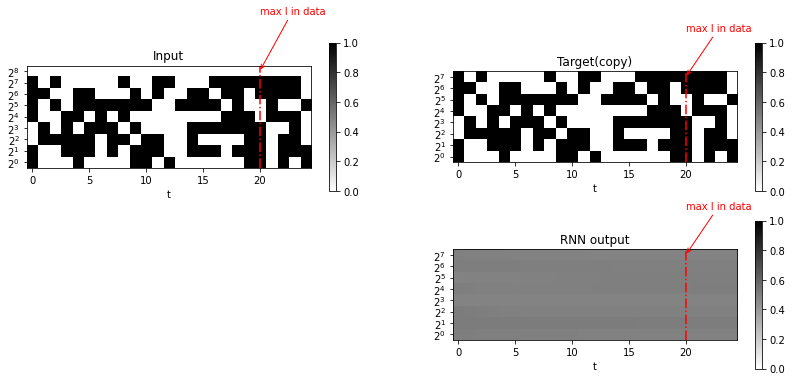

10000-epoch, model saved


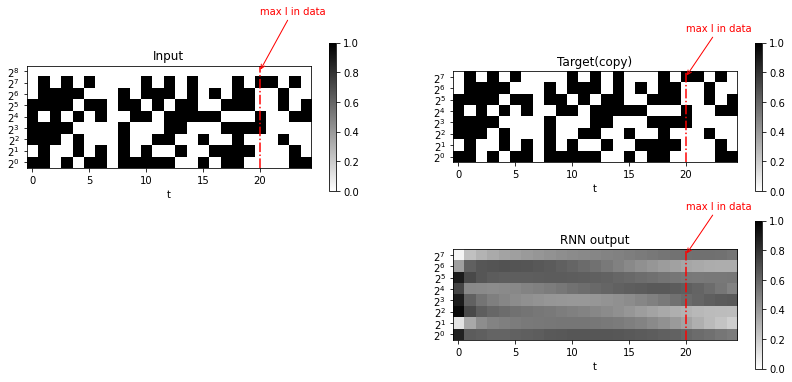

29000-epoch, model saved


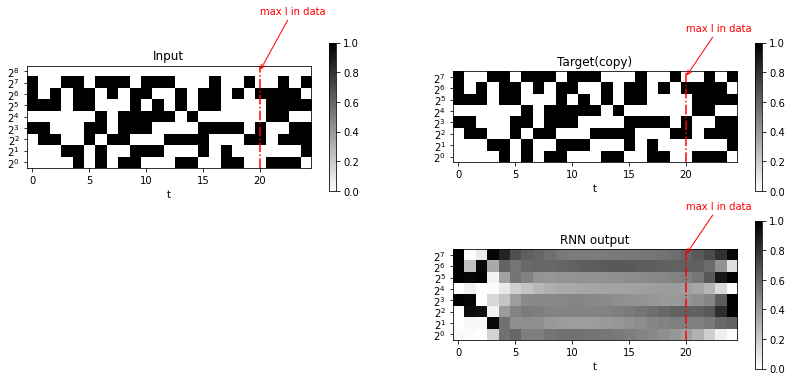

In [21]:
vec_dim, seq_length = 8, 20
data_size, batch_size= 1, 1
f = copy # reverse, sort is also implemented

cell = tf.keras.layers.LSTMCell(100)
model = NaiveModel(vec_dim, cell, batch_size=batch_size)
test_model = NaiveModel(vec_dim, cell, batch_size=1)

# training just by dataset w/ seq_length
#D = get_binary_dataset(seq_length, vec_dim, size=512, f=f)
#train(model, D, epoch_size=5000, batch_size=batch_size, savepath='LSTM_test')
# training by dataset w/ <= seq_length
train_various_seq(model, test_model, vec_dim, seq_length, f, data_size=data_size, 
                  epoch_size=30000, batch_size=batch_size, savepath='LSTM_test')

実際に実行すると、`tf.function()` の再トレーシング（グラフの組み直し）が発生し、警告が出されてしまいます。これは訓練で毎回時系列長さを変えているため生じますが、そのうち全パターンの長さのグラフが構成されるためか、警告が出なくなって、そのまま放置で訓練されます。また、500epochs毎に途中経過が出力されるようにしましたが、`train_various_seq`の`if epoch%500 == 0:`の条件分枝を書き換えれば出力するタイミングを変えることもできます。

### 極端に長い時系列について汎化しているか
ここでは時系列長さ20以内で訓練しましたが、それより極端に長い時系列データを入れてもアルゴリズム処理できるでしょうか？以下で確認できます。

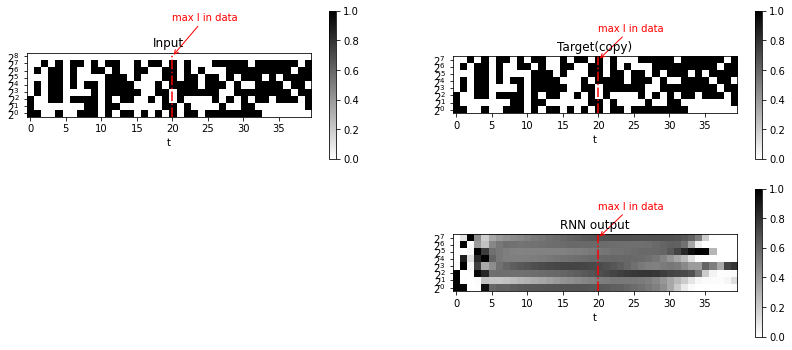

In [23]:
test_model = NaiveModel(vec_dim, cell, batch_size=1)
test_model.load_weights('LSTM_test')
X = tf.constant([random_X(seq_length+20, vec_dim)], dtype=tf.float32)
test(X, test_model, f=f, given_seq_length=seq_length, bin=False, threshold=0.5, w=False, show=True)

訓練が不十分な気もしますが、初めの方の処理以外は忘れてしまって上手く処理できないのがわかります。この節では訓練に使った長さの処理を大きく超えて、このような極端に長い時系列についてもターゲット関数と同じ処理をするニューラルネットワークを構成することを目標にします。